In [1]:
# To being please install PyPlot by uncomment the line below
# Pkg.add("PyPlot")
using PyPlot
srand(4242); # Reseed the random number generator with 4242

INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


For these examples we will be using the convex optimization function $ f(x) = \frac{1}{2} x^2 $ because the gradient is simply $ f(x) = x $ as such the function is as follows:

In [2]:
# Logistic Loss
# function logloss(z)
#     return log(1.0 .+ exp(z))
# end
# function grad_f(x)
#     return 1.0 ./ (1.0 .+ exp(-x)) 
# end

# Quadratic
function grad_f(x)
    return x
end

# Sigmoid
# function sigmoid(z)
#     return 1.0 ./ (1.0 .+ exp(-z)) 
# end
# function grad_f(x)
#     result = map(x_star -> sigmoid(x_star),x)
#     return result .* (1.0 - result)
# end

grad_f (generic function with 1 method)

Suppose that our samples are of the form
$$\tilde f(x) = \frac{1}{1 + e^{-x}}$$
where $z \sim N(0,1)$ is a standard Gaussian random variable. Then
$$ \nabla \tilde f(x) = \sigma(x)(1-\sigma(x)) + z $$
As such with each step the simplified SGD function would be:
$$x_{t+1} = x_t-\alpha\nabla \tilde f(x_t)$$

In [3]:
function sample_func_creater(x)
    noise = randn(length(x)) / sqrt(length(x))
    return (y -> y + noise)
end

sample_func_creater (generic function with 1 method)

In [4]:
function gradient_descent(x0, alpha, num_iters)
    dist_to_optimum = zeros(num_iters) # Distance to optimimum is initialized
    x = x0 # set x = initial x0
    for t = 1:num_iters # set num_iters
        dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
        x = x - alpha * grad_f(x) # this is running the simple GD equation without sampling
    end
    return dist_to_optimum
end

function stochastic_gradient_descent(x0, alpha, num_iters)
    dist_to_optimum = zeros(num_iters) # Distance to optimium is initialized
    x = x0 # set x = initial x0
    for t = 1:num_iters # set num_iters
        sample_grad_f = sample_func_creater(x)
        dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
        x = x - alpha * sample_grad_f(x) # this is the running the SGD
    end
    return dist_to_optimum
end

stochastic_gradient_descent (generic function with 1 method)

If we were to add SGD + VR
$$x_{t+1} = x_t-\alpha(\nabla \tilde f(x_t)-\nabla \tilde f( \tilde x_t) + \tilde \mu)$$

In [5]:
# Implementing SVRG
function stochastic_varience_reduced_gradient(x0, alpha, num_epochs, num_iters)
    # initial seeding of dist_to_optimum 
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = []
    x = x0
    for e = 1:num_epochs # Run for num_epochs
        x_tilda = x # assuming you are taking the optimized value instead of random
        mu = grad_f(x_tilda) # taking gradient of with respect to all x_tilda
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            sampler = sample_func_creater(x)
            x = x - alpha * (sampler(x)-sampler(x_tilda) + mu) # this is the running the SGD
        end
        append!(final_dist_to_optimum,dist_to_optimum)
    end
    return final_dist_to_optimum
end

stochastic_varience_reduced_gradient (generic function with 1 method)

In [6]:
x0 = 5 * randn(1000);
num_iters = 1000000;
num_epochs = 3;
accuracy = 1.0;

In [7]:
function stochastic_gradient_descent_diminishing(x0, num_iters)
    dist_to_optimum = zeros(num_iters)
    alphas = zeros(num_iters)
    x = x0
    mu = 1.0
    M = 1.0
    rho0 = norm(x0)^2
    for t = 1:num_iters
        sampler = sample_func_creater(x)
        alpha = (2 * mu * rho0) / (4 * M + mu^2 * rho0 * (t-1))
        alphas[t] = alpha
        dist_to_optimum[t] = norm(x)
        x = x - alpha * sampler(x)
    end
    return (alphas, dist_to_optimum)
end

stochastic_gradient_descent_diminishing (generic function with 1 method)

In [8]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha1 = 0.5 * norm(x0)^2; # same as first step
alpha2 = 2 / (4 + norm(x0)^2 * 100); # intermediate
alpha3 = 2 / (4 + norm(x0)^2 * 1000); # same as last step

sgd = stochastic_gradient_descent(x0, alpha3, 10000);
svgd = stochastic_varience_reduced_gradient(x0, alpha3, 10, 1000);

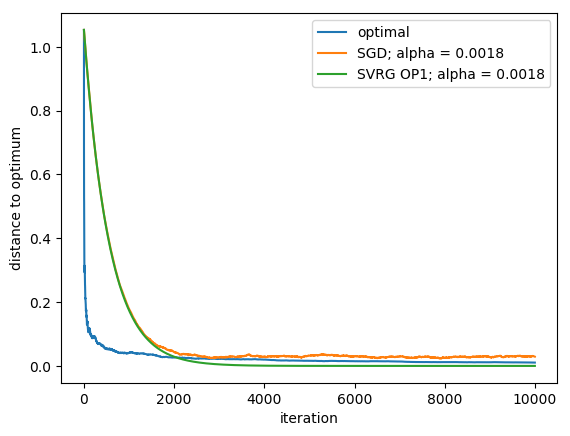

In [9]:
plot(dto_diminishing, label="optimal");
plot(sgd; label = "SGD; alpha = $(signif(alpha3, 2))");
plot(svgd; label = "SVRG OP1; alpha = $(signif(alpha3, 2))");
xlabel("iteration");
ylabel("distance to optimum");
legend();

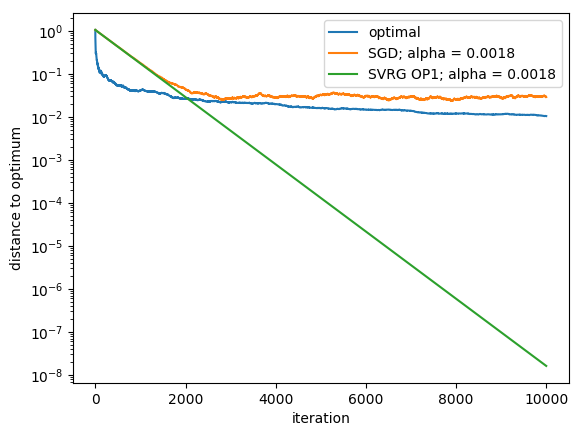

In [10]:
semilogy(dto_diminishing, label="optimal");
semilogy(sgd; label = "SGD; alpha = $(signif(alpha3, 2))");
semilogy(svgd; label = "SVRG OP1; alpha = $(signif(alpha3, 2))");
xlabel("iteration");
ylabel("distance to optimum");
legend();

In [11]:
numbahh = 0.03125*5 + 1.1
FI = 5
epsi = 2.0^(-FL)
floor((numbahh/epsi))

LoadError: UndefVarError: FL not defined

In [12]:
using StatsBase
items = [0,1]
weights = [0.1,0.9]
sample(items, Weights(weights))

INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.5/StatsBase.ji for module StatsBase.


1

In [97]:
using FixedPointNumbers
using StatsBase
function quantize_func_creater(IL,FL)
    # Stochastic Rounding
    epsi = 2.0^(-FL)
    w_helper = (num -> (num/epsi) - floor((num/epsi)))
    w_calc = (num -> [w_helper(num),1.0- w_helper(num)])
    rounder = (weights -> epsi*(sample([0,1], Weights(1-weights))))
    return (value -> convert(Fixed{IL,FL},floor(value/epsi)*epsi + rounder(w_calc(value))))
end    

quantize_func_creater (generic function with 1 method)

In [191]:
rand([0,1])

0

In [30]:
using Base
import Base

In [150]:
d = 1./128;
b = 32;

In [176]:
f = 0.005
value = (f/d)
num = floor(value/2.0^(-b))*2.0^(-b)
float(Fixed{Int32,31}(num))*d

0.004974365234375

In [190]:
widen1(Int16)

LoadError: UndefVarError: widen1 not defined

In [170]:
Union{Int8,Int16}

Union{Int16,Int8}

In [167]:
value = nummms/(2.0^(-16))
floor(value)*(2.0^(-16))

0.04998779296875

In [243]:
q = quantize_func_creater(Int8,7)
mean([Float64(q(0.4)) for k = 1:100000])

0.39999515625

When looking at strategies for precision this changes as there are 5 different options that we are looking at:
1. $x_{t+1} = x_t-Q(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t) + \alpha \tilde \mu)$ where we implmenent naive low-precision SVRG

In [251]:
# Implementing SVRG + Precision Option 1
function stochastic_varience_reduced_gradient_precision(x0, alpha, num_epochs, num_iters,FL,IL=Int8)
    # initial seeding of dist_to_optimum 
    q = quantize_func_creater(IL,FL)
    mq(arr) = map(v -> q(v),arr)
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = []
    x = map(v -> q(v), x0)
    for e = 1:num_epochs # Run for num_epochs
        x_tilda = x # assuming you are taking the optimized value instead of random
        mu = grad_f(x_tilda) # taking gradient of with respect to all x_tilda
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            sampler = sample_func_creater(x)
#             x = x - q(alpha) * (mq(sampler(x))-mq(sampler(x_tilda)) + mq(mu))
            x = x - mq(alpha * (sampler(x)-sampler(x_tilda) + mu))
        end
        append!(final_dist_to_optimum,dist_to_optimum)
    end
    return final_dist_to_optimum
end

stochastic_varience_reduced_gradient_precision (generic function with 2 methods)

In [254]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha = 2 / (4 + norm(x0)^2 * 1000); # same as last step
IL = Int8;
FL = 7;
sgd = stochastic_gradient_descent(x0, alpha, 10000);
svgd = stochastic_varience_reduced_gradient(x0, alpha, 10, 1000);
svgdp1 = stochastic_varience_reduced_gradient_precision(x0, alpha, 10, 1000,FL,IL);

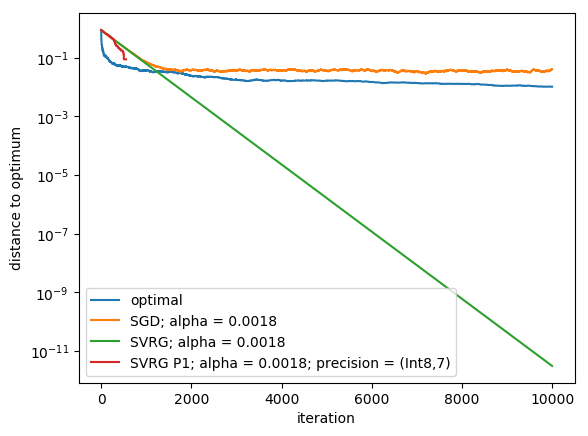

In [255]:
semilogy(dto_diminishing, label="optimal");
semilogy(sgd; label = "SGD; alpha = $(signif(alpha3, 2))");
semilogy(svgd; label = "SVRG; alpha = $(signif(alpha3, 2))");
semilogy(svgdp1; label = "SVRG P1; alpha = $(signif(alpha3, 2)); precision = ($IL,$FL)");
xlabel("iteration");
ylabel("distance to optimum");
legend();

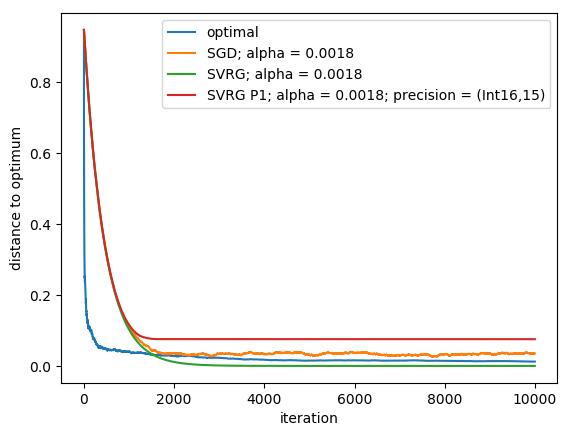

In [129]:
plot(dto_diminishing, label="optimal");
plot(sgd; label = "SGD; alpha = $(signif(alpha3, 2))");
plot(svgd; label = "SVRG; alpha = $(signif(alpha3, 2))");
plot(svgdp1; label = "SVRG P1; alpha = $(signif(alpha3, 2)); precision = ($IL,$FL)");
xlabel("iteration");
ylabel("distance to optimum");
legend();

2 .  $x_{t+1} = x_t-Q(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t)) - g_z$ ; $g_z = Q(\alpha\tilde \mu)$ where we Quantize $\alpha\tilde \mu$ as soon as it's computed

In [120]:
# Implementing SVRG + Precision Option 2
function stochastic_varience_reduced_gradient_precision_2(x0, alpha, num_epochs, num_iters,FL,IL=Int8)
    # initial seeding of dist_to_optimum 
    q = quantize_func_creater(IL,FL)
    mq(arr) = map(v -> q(v),arr)
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = []
    x = map(v -> q(v), x0)
    for e = 1:num_epochs # Run for num_epochs
        x_tilda = x # assuming you are taking the optimized value instead of random
        mu = mq(grad_f(x_tilda)) # taking gradient of with respect to all x_tilda
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            sampler = sample_func_creater(x)
            x = x - q(alpha) * (mq(sampler(x))-mq(sampler(x_tilda)) + mu)
        end
        append!(final_dist_to_optimum,dist_to_optimum)
    end
    return final_dist_to_optimum
end

stochastic_varience_reduced_gradient_precision_2 (generic function with 2 methods)

In [121]:
x0 = randn(100) / 10;
(alphas, dto_diminishing) = stochastic_gradient_descent_diminishing(x0, 10000);

alpha = 2 / (4 + norm(x0)^2 * 1000); # same as last step
IL = Int32;
FL = 31;
sgd = stochastic_gradient_descent(x0, alpha, 10000);
svgd = stochastic_varience_reduced_gradient(x0, alpha, 10, 1000);
svgdp1 = stochastic_varience_reduced_gradient_precision(x0, alpha, 10, 1000,FL,IL);
svgdp2 = stochastic_varience_reduced_gradient_precision_2(x0, alpha, 10, 1000,FL,IL);

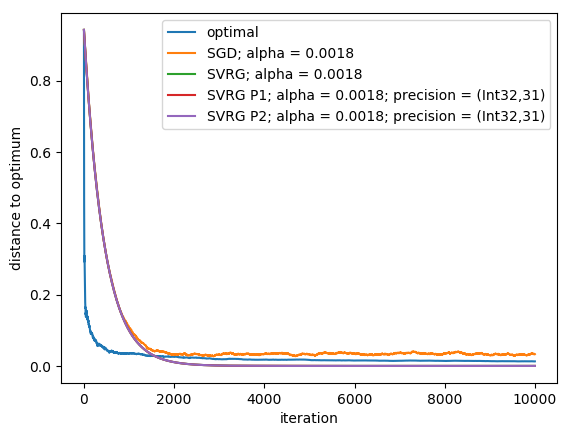

In [124]:
plot(dto_diminishing, label="optimal");
plot(sgd; label = "SGD; alpha = $(signif(alpha3, 2))");
plot(svgd; label = "SVRG; alpha = $(signif(alpha3, 2))");
plot(svgdp1; label = "SVRG P1; alpha = $(signif(alpha3, 2)); precision = ($IL,$FL)");
plot(svgdp2; label = "SVRG P2; alpha = $(signif(alpha3, 2)); precision = ($IL,$FL)");
xlabel("iteration");
ylabel("distance to optimum");
legend();

3 . $x_{t+1} = x_t-Q_b(\alpha \nabla \tilde f(x_t)-\alpha \nabla \tilde f( \tilde x_t)) + \alpha g_z$ ; $g_z = Q_{2b}(\tilde \mu)$ 

In [123]:
# Implementing SVRG + Precision Option 2
function stochastic_varience_reduced_gradient_precision_3(x0, alpha, num_epochs, num_iters,FL,IL=Int8)
    # initial seeding of dist_to_optimum 
    q = quantize_func_creater(IL,FL)
    mq(arr) = map(v -> q(v),arr)
    dist_to_optimum = zeros(num_iters)
    final_dist_to_optimum = []
    x = map(v -> q(v), x0)
    for e = 1:num_epochs # Run for num_epochs
        x_tilda = x # assuming you are taking the optimized value instead of random
        mu = mq(grad_f(x_tilda)) # taking gradient of with respect to all x_tilda
        for t = 1:num_iters # set num_iters
            dist_to_optimum[t] = norm(x) # the distance to optimum is the norm
            sampler = sample_grad_f(x)
            x = x - q(alpha) * (mq(sampler(x))-mq(sampler(x_tilda)) + mu)
        end
        append!(final_dist_to_optimum,dist_to_optimum)
    end
    return final_dist_to_optimum
end

stochastic_varience_reduced_gradient_precision_3 (generic function with 2 methods)

4 This is the hybrid version with the following proof to show that the size of the ball radius is $\frac{1}{\mu}||\nabla f(x)||$
$$(x-x^*)^T(\nabla f(x) - \nabla f(x^*))\geq \mu ||x-x^*||^2$$
$$(x-x^*)^T(\nabla f(x) - \nabla f(x^*))\geq ||x-x^*|| * ||\nabla f(x) - \nabla f(x^*)||$$
$$\mu ||x-x^*||^2 \leq ||x-x^*|| * ||\nabla f(x) - \nabla f(x^*)||$$
$$||x-x^*|| \leq \frac{1}{\mu}||\nabla f(x)||$$

As such, for each iteration of calculating $\mu$ you will calculate radius
$$w=w^*+s\mu$$ where $\mu$ is calculated as some smaller bit 

In [211]:
dimensionality = 20; # dimensions
num_samples = 10000; # samples
function log_reg_input(d,N)
    wtrue = randn(d);
    wtrue = d^2 * wtrue / norm(wtrue);
    X = randn(N, d);
    X ./= sqrt(sum(X.^2, 2));
    Y = (1 ./ (1 + exp(-X * wtrue)) .>= rand(N)) * 2 - 1;
    return (X,Y)
end
(X,Y) = log_reg_input(dimensionality,num_samples);

In [215]:
d = 20;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt(sum(X.^2, 2));
Y = (1 ./ (1 + exp(-X * wtrue)) .>= rand(N)) * 2 - 1;
sigma = 0.001;
(X,Y)

(
[-0.134366 -0.266733 … -0.259892 0.276071; -0.0771605 0.189025 … -0.0177521 -0.261867; … ; -0.122743 0.218092 … -0.230096 -0.155942; -0.182901 -0.324474 … 0.241918 -0.137279],

[1,1,1,1,1,-1,-1,-1,1,1  …  -1,1,1,-1,-1,1,-1,1,1,1])

We will set $\mu = \sigma$ and $L = \sigma + \frac{1}{4}$

In [216]:
sigma = 0.001;
mu = sigma;
L = sigma + 0.25;
M = 1;

$w_t = (1-a\sigma)*w_{t-1} + \frac{\alpha x_i y_i}{1+\exp(y_i(x_i*w_{t-1}))}$

In [217]:
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 + exp(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 + exp(Y .* (X * w))) .* (1 + exp(-Y .* (X * w))))) .* X) + N * sigma * eye(d);
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end
function stochastic_varience_reduced_gradient_lreg(w0, a0, gamma, X, Y, sigma, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        a = a0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - a * sigma) * w + a * xi * yi / (1 + exp(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

stochastic_varience_reduced_gradient_lreg (generic function with 1 method)

In [218]:
w0 = randn(d);
wopt = newton_logreg(wtrue, X, Y, sigma, 10);
alpha0 = 2 * mu * norm(w0 - wopt)^2 / (4 * M);
gamma = mu^2 * norm(w0 - wopt)^2 / (4 * M);

gradient norm: 3999.976544589084
gradient norm: 900.5222698717437
gradient norm: 233.07947636657903
gradient norm: 59.093260538840745
gradient norm: 5.94461860364807
gradient norm: 0.06936885111142446
gradient norm: 9.590264139133098e-6
gradient norm: 4.576785852864383e-13
gradient norm: 1.0408801218160778e-13
gradient norm: 5.710389793476629e-14


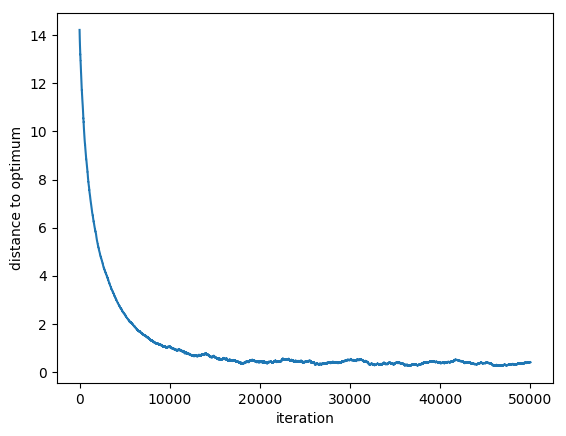

In [219]:
(w, dto) = stochastic_varience_reduced_gradient_lreg(w0, alpha0, gamma, X, Y, sigma, 50000, wopt);
plot(dto)
xlabel("iteration");
ylabel("distance to optimum");

In [ ]:
function stochastic_varience_reduced_gradient_log_reg_precision(w0, alpha0, gamma, X, Y, sigma, 50000, wopt,FL,IL=Int8)
    # initial seeding of dist_to_optimum 
    q = quantize_func_creater(IL,FL)
    mq(arr) = map(v -> q(v),arr)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        a = a0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - a * sigma) * w + a * xi * yi / (1 + exp(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end